<a href="https://colab.research.google.com/github/arghyadeep99/PokeGAN/blob/master/PokeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install visdom
#!pip install -q kaggle

# Setting up Kaggle with Colab to get Kaggle Datasets

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle config set -n path -v{/content}

In [0]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset -p /content

 96% 129M/134M [00:01<00:00, 80.3MB/s]
100% 134M/134M [00:01<00:00, 86.5MB/s]


In [0]:
!mkdir train
!unzip complete-pokemon-image-dataset.zip -d train

# Import Functions

In [0]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as tvutils
import torch.utils.data as datautils
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# use gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Utility Functions

In [0]:
# return iterable over dataset that will load minibatches (size = 128) for training
# preprocessing: images are resized to 64x64, each channel is normalized with mean = 0.5, s = 0.5
def get_loader(datapath):
    dataset = datasets.ImageFolder(root=datapath,transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    loader = datautils.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
    return loader

In [0]:
# view training data sample images as 8x8 grid
def view_images(loader):
    sample = next(iter(dataloader))
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.title('Dataset Sample Images')
    plt.imshow(np.transpose(tvutils.make_grid(sample[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Generator and Discriminator Models

In [0]:
class Generator(nn.Module):
    def __init__(self, z_size=100, num_channels=3, gfm_size=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # input layer (latent vector z taken as input)
            nn.ConvTranspose2d(z_size, gfm_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gfm_size * 8),
            nn.ReLU(True),
            
            # state size: (gfm_size * 8) x 4 x 4
            nn.ConvTranspose2d(gfm_size * 8, gfm_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size * 4),
            nn.ReLU(True),
            
            # state size: (gfm_size * 4) x 8 x 8
            nn.ConvTranspose2d( gfm_size * 4, gfm_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size * 2),
            nn.ReLU(True),
            
            # state size: (gfm_size * 2) x 16 x 16
            nn.ConvTranspose2d( gfm_size * 2, gfm_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size),
            nn.ReLU(True),
            
            # state size: (gfm_size) x 32 x 32
            nn.ConvTranspose2d(gfm_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # output: num_channels x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=3, dfm_size=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # input: num_channels x 64 x 64 
            nn.Conv2d(num_channels, dfm_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: dfm_size x 32 x 32
            nn.Conv2d(dfm_size, dfm_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 2) x 16 x 16
            nn.Conv2d(dfm_size * 2, dfm_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 4) x 8 x 8
            nn.Conv2d(dfm_size * 4, dfm_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 8) x 4 x 4
            nn.Conv2d(dfm_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        # view(-1) flattens the output from 2D to 1D 
        return self.main(input).view(-1)

In [0]:
# initialize all model weights
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Importing the data

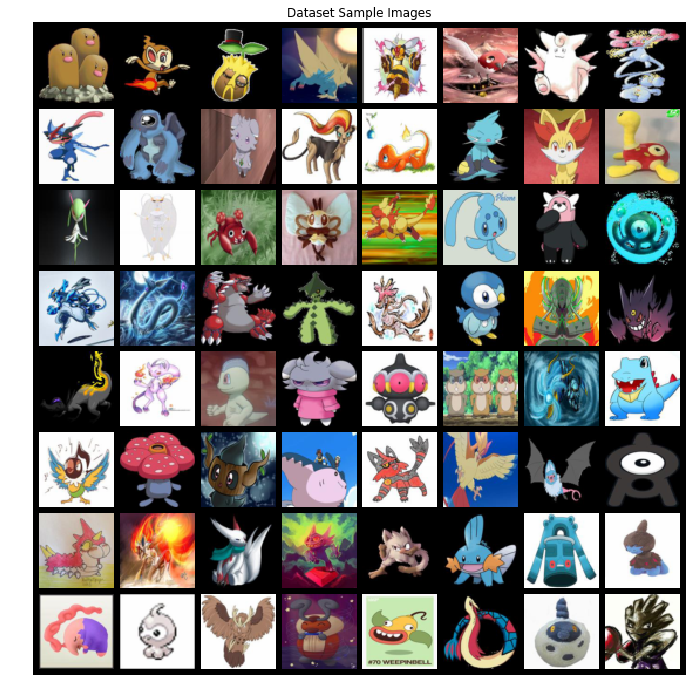

In [0]:
path = '/content/train'
dataloader = get_loader(path)
view_images(dataloader)

In [0]:
num_epochs = 50
z_size = 100
real_label = 1
fake_label = 0

# creating generator and discriminator networks
gen_net = Generator().to(device)
disc_net = Discriminator().to(device)

# init_weights is applied to self and every submodule recursively
gen_net.apply(init_weights)
disc_net.apply(init_weights)

print(gen_net, disc_net)

# create criterion to measure error (binary cross entropy between target and output)
bce_loss = nn.BCELoss()

# create Adam SGD optimizers with learning rate 0.0002 and beta1 = 0.5
gen_opt = optim.Adam(gen_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = optim.Adam(disc_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# noise used for visualizing generator's learning curve 
test_noise = torch.randn(64, z_size, 1, 1, device=device)

image_lst = []
gen_losses = []
disc_losses = []
num_iter = 0

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
) 

# Training Time!

In [0]:
from tqdm import tqdm
for epoch in range(num_epochs):
    for idx,data in enumerate(dataloader):
        
        # DISCRIMINATOR UPDATE

        # set gradients of all model parameters to zero
        disc_net.zero_grad()
        
        # get batch of all real images
        real_batch = data[0].to(device)
        batch_size = real_batch.size(0)
        labels = torch.full((batch_size,), real_label, device=device)
        
        # forward pass real batch through discriminator
        output = disc_net(real_batch)
        disc_loss_real = bce_loss(output, labels)
        
        # calculate gradients for discriminator in backward pass
        disc_loss_real.backward()
        Dx_value = output.mean().item()
        
        # get batch of all fake images
        latent_z = torch.randn(batch_size, z_size, 1, 1, device=device)
        fake_batch = gen_net(latent_z)
        labels.fill_(fake_label)
        
        # classify fake images using discriminator
        output = disc_net(fake_batch.detach())
        disc_loss_fake = bce_loss(output, labels)
        
        # calculate gradients for discriminator in backward pass
        disc_loss_fake.backward()
        DGz_value_1 = output.mean().item()
        
        # add gradients from both batches, save total loss
        disc_loss = disc_loss_real + disc_loss_fake
        disc_losses.append(disc_loss.item())
        
        # update discriminator
        disc_opt.step()
        
        # GENERATOR UPDATE
        
        # set gradients of all model parameters to zero
        gen_net.zero_grad()
        
        # fake labels are "real" in terms of generator cost
        labels.fill_(real_label)
        
        # after updating discriminator, perform another forward pass of fake batch
        output = disc_net(fake_batch)
        
        # calculate and save generator loss on discriminator's new output 
        gen_loss = bce_loss(output, labels)
        gen_losses.append(gen_loss.item())
        
        # calculate gradients for generator in backward pass
        gen_loss.backward()
        DGz_value_2 = output.mean().item()
        
        # update generator
        gen_opt.step()
        
        # print update every 100th batch
        if idx % 100 == 0:
            print('Epoch: %d/%d Idx: %d/%d\nLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, idx, len(dataloader),
                disc_loss.item(), gen_loss.item(), Dx_value, DGz_value_1, DGz_value_2))
        
        # periodically test and save generator performance on test_noise
        # do not calculate gradients
        if (num_iter % 500 == 0) or ((epoch == num_epochs-1) and (idx == len(dataloader)-1)):           
            with torch.no_grad():
                fake_image = gen_net(test_noise).detach().cpu()
            image_lst.append(tvutils.make_grid(fake_image, padding=2, normalize=True))
        
        num_iter += 1

Epoch: 0/50 Idx: 0/193
Loss_D: 0.4989	Loss_G: 4.0184	D(x): 0.8581	D(G(z)): 0.2533 / 0.0280
Epoch: 0/50 Idx: 100/193
Loss_D: 0.6676	Loss_G: 5.1327	D(x): 0.8256	D(G(z)): 0.3221 / 0.0120
Epoch: 1/50 Idx: 0/193
Loss_D: 0.8964	Loss_G: 6.1462	D(x): 0.9775	D(G(z)): 0.5211 / 0.0043
Epoch: 1/50 Idx: 100/193
Loss_D: 1.4442	Loss_G: 5.5510	D(x): 0.8659	D(G(z)): 0.5901 / 0.0238
Epoch: 2/50 Idx: 0/193
Loss_D: 0.4821	Loss_G: 3.6368	D(x): 0.7765	D(G(z)): 0.1330 / 0.0422
Epoch: 2/50 Idx: 100/193
Loss_D: 0.3847	Loss_G: 2.6733	D(x): 0.8417	D(G(z)): 0.1580 / 0.1208
Epoch: 3/50 Idx: 0/193
Loss_D: 0.6774	Loss_G: 2.8307	D(x): 0.6063	D(G(z)): 0.0812 / 0.0915
Epoch: 3/50 Idx: 100/193
Loss_D: 1.7156	Loss_G: 0.8593	D(x): 0.2670	D(G(z)): 0.0114 / 0.4794
Epoch: 4/50 Idx: 0/193
Loss_D: 0.6365	Loss_G: 3.5705	D(x): 0.8721	D(G(z)): 0.3339 / 0.0507
Epoch: 4/50 Idx: 100/193
Loss_D: 0.6160	Loss_G: 2.4063	D(x): 0.6761	D(G(z)): 0.1330 / 0.1337
Epoch: 5/50 Idx: 0/193
Loss_D: 0.5887	Loss_G: 2.7756	D(x): 0.8051	D(G(z)): 0.265

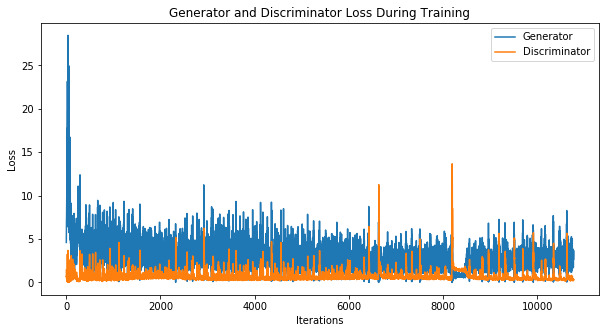

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="Generator")
plt.plot(disc_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generating our new Pokémons! 

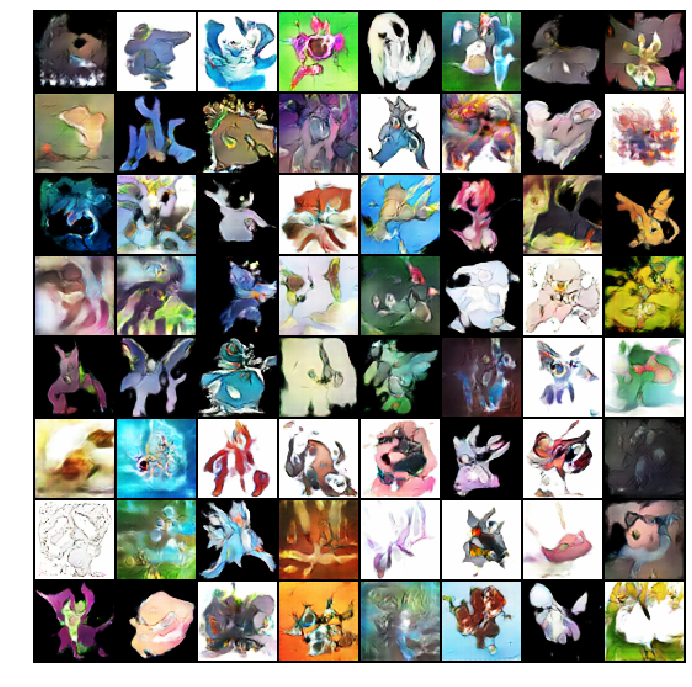

In [0]:
# generate 12x12" figure, axes off, showing progression of generated images
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in image_lst]

# More Ideas for applying GANs:

1. Super resolution on your government IDs. (We know how horrible we all look in those).
2. Filling in missing values of images by letting the GANs guess how that area should be filled
3. Generating masks for identifying components in an image. For eg: mask of a car to find car instances in an image.
4. DeepFakes (Do we even need to mention it?)
5. Your own anime characters! 